Smoothed NDVI

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from p_drought_indices.functions.ndvi_functions import get_irradiances, compute_ndvi_corr

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

ndvi_dir = config_file['NDVI']['ndvi_prep']
    
new_dir = os.path.join(ndvi_dir,"new_process")
list_files_2 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]

ds = xr.open_dataset(list_files_2[1000])

msg_type = ds.attrs['EPCT_product_name'][:4]

girradiance_vis6, irradiance_vis8 = get_irradiances(msg_type)

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

# Open the NetCDF file with xarray
ds = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))
ds_ndvi = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_prep'], 'final_ndvi.nc'))
ds_smoot = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))
vci = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'vci_1D.nc'))

In [ ]:
import pandas as pd 
from datetime import timedelta

from p_drought_indices.analysis.visualizations.viz_series import plot_ndvi_days

plot_ndvi_days(ds_smoot,
               start_day="2010-01-01",
                num_timesteps=15)

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing, get_lat_lon_window
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import pickle

CONFIG_PATH= "../config.yaml"

time_end = "2019-12-31"
time_start = "2005-01-01"


def spi_ndvi_convlstm():
    config_file = load_config(CONFIG_PATH=CONFIG_PATH)

    # Open the NetCDF file with xarray
    dataset = prepare(xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))).sel(time=slice(time_start,time_end))

    prod = "ERA5"
    late = 90

    path = config_file['SPI']['ERA5']['path']
    file = "era5_land_merged.nc" #f"ERA5_spi_gamma_{late}.nc"
    precp_ds = xr.open_dataset(os.path.join(path, file))
    var_target = "spi_gamma_{}".format(late)
    print(f"The {prod} raster has spatial dimensions:", precp_ds.rio.resolution())

    #### training parameters
    train_split = 0.8
    batch_size=4
    dim=64
    preprocess_type="None"

    ### Load dataset
    file_path = os.path.join(config_file["DEFAULT"]["data"],'preprocessed_data.pkl')
    if os.path.exists(file_path):
        print("The file exists. Proceeding with the analysis")
        with open(file_path, 'rb') as file:
            train_data, test_data, train_label, test_label = pickle.load(file)
    else:
        print("The file does not exist. Proceeding with preprocessing")
        idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)
        sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
            .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))
        ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})

        

        train_data, test_data, train_label, test_label = CNN_preprocessing(ds, sub_precp, var_origin="ndvi", var_target=var_target, preprocess_type=preprocess_type,  split=train_split)
        # Save the image data using pickle
        with open(file_path, 'wb') as file:
            pickle.dump((train_data, test_data, train_label, test_label), file)
        print("Data written to pickle file")

    # create a CustomDataset object using the reshaped input data
    train_dataset = CustomDataset(train_data, train_label)
    test_dataset = CustomDataset(test_data, test_label)
    
    # create a DataLoader object that uses the dataset
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    
    ### check shape of data
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    
    
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())


    #### Start training

    from p_drought_indices.configs.config_3x3_16_3x3_32_3x3_64 import config
    from torch.nn import MSELoss
    import matplotlib.pyplot as plt
    from p_drought_indices.analysis.DeepLearning.ConvLSTM import ConvLSTM, train_loop, valid_loop, build_logging
    import numpy as np
    
    name = '3x3_16_3x3_32_3x3_64'
    
    logger = build_logging(config)
    model = ConvLSTM(config).to(config.device)
    #criterion = CrossEntropyLoss().to(config.device)
    #criterion = torch.nn.MSELoss().to(config.device)
    criterion = MSELoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_records, valid_records, test_records = [], [], []
    for epoch in range(config.epochs):
        epoch_records = train_loop(config, logger, epoch, model, train_dataloader, criterion, optimizer)
        train_records.append(np.mean(epoch_records['loss']))
        epoch_records = valid_loop(config, logger, epoch, model, test_dataloader, criterion)
        valid_records.append(np.mean(epoch_records['loss']))
        plt.plot(range(epoch + 1), train_records, label='train')
        plt.plot(range(epoch + 1), valid_records, label='valid')
        plt.legend()
        plt.savefig(os.path.join(config.output_dir, '{m}_{n}.png'.format(n=name, m=preprocess_type)))
        plt.close()
    

In [ ]:
spi_ndvi_convlstm()

In [2]:
import xarray as xr
import os
import numpy as np
from p_drought_indices.functions.function_clns import load_config, subsetting_pipeline
from datetime import datetime
import pandas as pd

CONFIG_PATH= "../config.yaml"
config_file = load_config(CONFIG_PATH)

In [22]:
import pandas as pd
from datetime import timedelta, datetime
from tqdm.auto import tqdm
from p_drought_indices.precipitation.data_collection.era5_daily_data import ee_collection
import xarray as xr
import os
from p_drought_indices.functions.function_clns import load_config, subsetting_pipeline

CONFIG_PATH= "../config.yaml"
config = load_config(CONFIG_PATH)

for day in tqdm(missing_days):
    print(f"Collecting day {day}...")
    new_day = pd.to_datetime(day) + timedelta(days=1)
    end_day = new_day.strftime("%Y-%m-%d")
    ee_collection(day, end_day)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:12<02:15, 12.28s/it]

 17%|█▋        | 2/12 [00:25<02:10, 13.03s/it]

 25%|██▌       | 3/12 [00:38<01:55, 12.83s/it]

 33%|███▎      | 4/12 [00:50<01:39, 12.43s/it]

 42%|████▏     | 5/12 [01:02<01:25, 12.19s/it]

 50%|█████     | 6/12 [01:14<01:13, 12.20s/it]

 58%|█████▊    | 7/12 [01:26<01:01, 12.25s/it]

 67%|██████▋   | 8/12 [01:37<00:47, 11.90s/it]

 75%|███████▌  | 9/12 [01:49<00:35, 11.82s/it]

 83%|████████▎ | 10/12 [01:59<00:22, 11.40s/it]

 92%|█████████▏| 11/12 [02:11<00:11, 11.49s/it]

100%|██████████| 12/12 [02:23<00:00, 11.94s/it]


In [2]:
from p_drought_indices.precipitation.data_collection.era5_daily_data import convert_tif_netcdf

base_path = config_file["SPI"]["ERA5"]["path"]
dest_path = os.path.join(base_path,"era5_netcdf")
path = os.path.join(base_path,"daily")

#convert_tif_netcdf(CONFIG_PATH, base_path, path, dest_path, use_gdal=True, compress=True)

In [3]:
import pandas as pd
path = os.path.join(base_path, "era5_land_merged.nc")
precp_ds = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(path))
### generate mask and count days  smaller than 0
mask = precp_ds['tp'] < 0
arr = mask.sum(dim=["lat","lon"])
print("Days with errors:", len(np.where(arr>0)[0]))
list_arr = np.where(arr>0)[0]
days = [np.datetime_as_string(precp_ds.isel(time=i)["time"].values, unit="D") for i in list_arr]
ds = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(base_path, "era5_precp_batch.nc"), chunks={"time":"200MB" }))
print("Collected days from ee:", len( np.unique(ds["time"].values)))

Days with errors: 1072
Collected days from ee: 1072


In [8]:
from p_drought_indices.functions.function_clns import prepare

ds = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(base_path, 
    "era5_precp_batch.nc"), chunks={"time":"200MB" }))
res_ds = prepare(ds)["tp"].rio.reproject_match(prepare(precp_ds)["tp"]) \
    .rename({"y":"lat", "x":"lon"})
days_dt = [np.datetime64(f) for f in days]
ds_1 = precp_ds.drop_sel(time = days_dt) 
ds_ = xr.concat([ds_1, res_ds.to_dataset()], dim="time")
ds_ = ds_.sortby("time")

In [40]:
ds_.to_netcdf(os.path.join(base_path,"era5_land_merged_corr.nc"))

In [44]:
# Compute a boolean mask for missing values
missing_mask = xr.where(np.isnan(ds_["tp"]), True, False)

# Collapse the time dimension to check if the mask values are constant over time
are_missing_values_constant = missing_mask.all(dim='time')

# Print the result
print(are_missing_values_constant)

<xarray.DataArray 'tp' (lat: 195, lon: 183)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 51.0 51.1 51.2 51.3
  * lat          (lat) float32 14.8 14.7 14.6 14.5 14.4 ... -4.3 -4.4 -4.5 -4.6
    spatial_ref  int32 0


In [12]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import data_preparation
from p_drought_indices.functions.function_clns import load_config

CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
sub_precp, ds =  data_preparation(CONFIG_PATH, precp_dataset="CHIRPS")

The CHIRPS raster has spatial dimensions: (0.25, -0.25)
NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
Precipitation dataset resolution (0.25, -0.25)


In [ ]:
from p_drought_indices.functions.function_clns import load_config
from p_drought_indices.analysis.visualizations.viz_vci_spi import plot_veg_event
import os
import xarray as xr
CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)

path = config["PRECIP"]["ERA5_land"]["path"]
output_dir = os.path.join(path,  "graph_net/predicted_data")

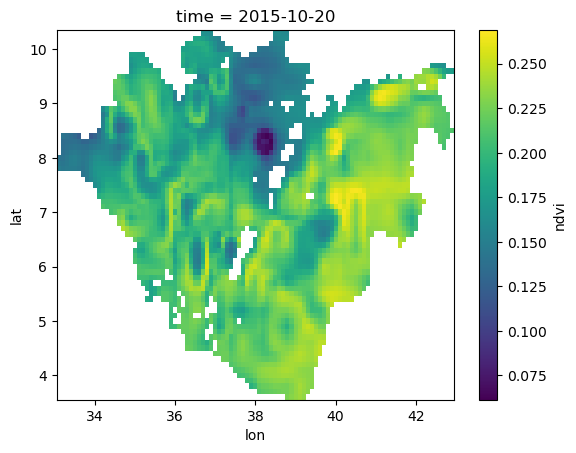

In [ ]:
ds = xr.open_dataset(os.path.join(output_dir, "predicted_ndvi_1.nc"))
ds.isel(time=0)["ndvi"].plot()

days are 366
Calculating the full year for boxplot
The days are 366
days are 365
For year 2017 obtaining only months 1 to 5 for boxplot


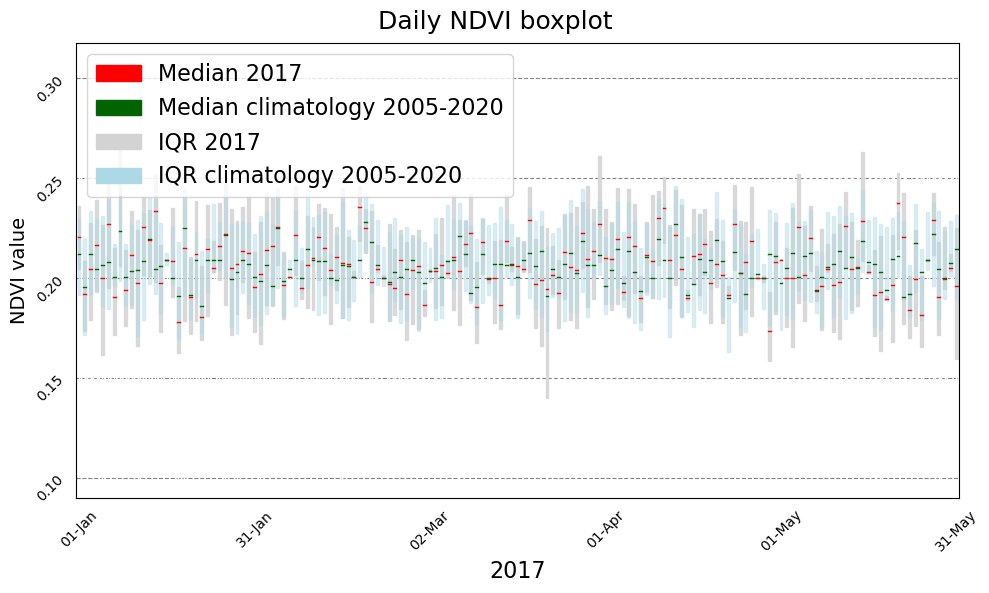

In [84]:
months = [i for i in np.arange(1,6)]
plot_veg_event(ds,year=2017, months=months)

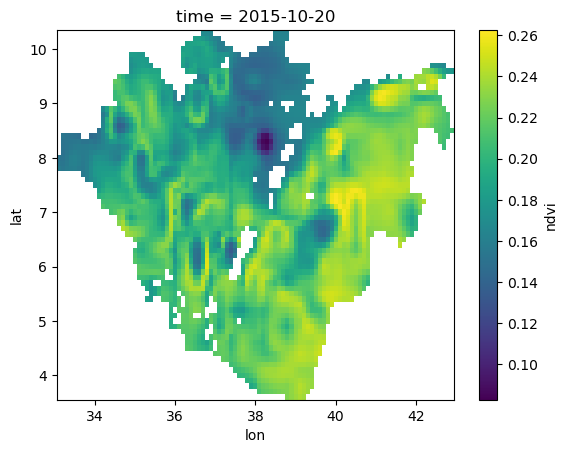

In [73]:
ds = xr.open_dataset(os.path.join(output_dir, "predicted_ndvi_2.nc"))
ds.isel(time=0)["ndvi"].plot()